In [1]:
import os
newestModel = True #If this is set to true it will use the newest model in the models folder and ignore modelToTest
modelToTest = ''
threads = 16 #Number of threads to use for multithreaded tasks
pathToModelFolder = '/home/jaredrussell/CPPMLGenMini/Models'
pathToDataFolder = '/home/jaredrussell/CPPDatasetMin'
#pathToDataFolder = '~/SPDataset/MiniTestingDataset'
#a folder inthe models folder contains the following files: model.h5, tokenizer.json commitHash.txt (For SCA-Tokenizer)
useCurrentSCATokenizer = '/home/jaredrussell/gitRepos/SCA-ML-grade/Model-Generation/SCA-Tokenizer' #If this is set to anything other than '' it will use the current SCA-Token in the SCA-Token folder and ignore the modelToTest

In [2]:
import os
import pickle
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
import json
import threading as th
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import sys
import subprocess
import time
import datetime
import random
import math
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import tokenizer_from_json



catigoryInputModel = False


def homePath(path):
    if path[0] == '~':
        return os.path.join(os.path.expanduser("~"), path.strip("~/"))
    else:
        return path

pathToModelFolder = homePath(pathToModelFolder)
pathToDataFolder = homePath(pathToDataFolder)

def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()


def searchFileName(path, fileName):
    filesToDo = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file == fileName:
                    filesToDo.append(os.path.join(root, file).split(path)[1])
    return filesToDo



2023-11-28 19:01:38.254433: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-28 19:01:38.284896: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 19:01:38.284922: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 19:01:38.285855: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-28 19:01:38.290599: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-28 19:01:38.290951: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
#File Loading

import sys
sys.path.append('./SCA-Tokenizer/')
sys.path.append('./TokenCatigoryGenerator')
import TokenizerManager
import TokenCatigoryApplier


if newestModel:
    models = os.listdir(pathToModelFolder)
    models.sort()
    modelToTest = models[-1]
    print("Using newest model: " + modelToTest)
else:
    print("Using model: " + modelToTest)
model = load_model(pathToModelFolder + '/' +modelToTest + '/model.h5')
print (model.summary())

#load tokenizer from json that used the .tokenizer.save() function
#check if it's .json or .pkl
if os.path.isfile(pathToModelFolder + '/' + modelToTest + '/tokenizer.pkl'):
    with open(pathToModelFolder + '/' + modelToTest + '/tokenizer.pkl', 'rb') as f:
        tokenizerModel = pickle.load(f)
else:
    with open(pathToModelFolder + '/' + modelToTest + '/tokenizer.json') as f:
        tokenizerModel = tokenizer_from_json(f.read())

#check if groupings are being used 
# check if GroupDict.npy exists
if os.path.isfile(pathToModelFolder + '/' + modelToTest + '/GroupDict.npy'):
    catigoryInputModel = True
    print("Using catigory input model")
    groupDict = np.load(pathToModelFolder + '/' + modelToTest + '/GroupDict.npy', allow_pickle=True).item()
    print(groupDict)


Using newest model: 2023-11-28_18-59-30-932847
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 64)           32000     
                                                                 
 conv1d (Conv1D)             (None, 498, 64)           12352     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 reshape (Reshape)           (None, 1, 64)             0         
                                                                 
 bidirectional (Bidirection  (None, 1, 128)            66048     
 al)                                                             
                                                                 
 dropout 

In [4]:


dfTokens = TokenizerManager.tokenStart(pathToDataFolder, tokenizer=tokenizerModel, multiThreadProcessing = False)

if catigoryInputModel:
    dfCatigories = TokenCatigoryApplier.translateTokens(groupDict, dfTokens)


    


completed folder index
Progressing (Not Multithreaded): |██████████████████████████████████████████████████| 100.0% Complete
Finishing
Tokenizing
                                           tokenCode  \████████████████████---------| 83.3% Complete
0   108 285 29 286 61 128 135 2 136 3 187 137 138...   
1   108 285 29 286 61 128 135 2 136 3 187 137 138...   
2   108 230 29 231 128 135 2 136 3 187 137 138 24...   
3   108 230 29 231 128 135 2 136 3 173 137 138 25...   
4   108 230 29 231 128 135 2 136 3 173 137 138 25...   
5   108 230 29 231 128 135 2 136 3 173 137 138 25...   

                        Path  
0    /52652/Button.cpp/0.cpp  
1    /52652/Button.cpp/1.cpp  
2  /52669/FancyLED.cpp/0.cpp  
3  /52669/FancyLED.cpp/2.cpp  
4  /52669/FancyLED.cpp/1.cpp  
5  /52669/FancyLED.cpp/3.cpp  


In [5]:
#Grading Code
sys.path.append('../Auto-Grader/')
import Grader
#prevent warnings from printing
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
dfGrades = Grader.bootstrap(pathToDataFolder)

6rocessing Files |█████████████████████████-------------------------| 50.0% Complete
   fileGrade                       Path
0       17.0    /52652/Button.cpp/0.cpp
1       27.0    /52652/Button.cpp/1.cpp
2        0.0  /52669/FancyLED.cpp/0.cpp
3        1.4  /52669/FancyLED.cpp/1.cpp
4        6.4  /52669/FancyLED.cpp/2.cpp
5       11.4  /52669/FancyLED.cpp/3.cpp
Time Taken: 0.0051116943359375


In [7]:
combinedDF = pd.merge(dfGrades, dfTokens, on = "Path")


In [8]:
#get max length of tokens from model
maxLen = model.layers[0].input_shape[1]
#combinedDF = combinedDF[combinedDF["tokenCode"].apply(lambda x: len(x)) <= maxLen]

#FOR TESTING, REDUCE TOKEN SIZE WHEN OVER maxLen
combinedDF["tokenCode"] = combinedDF["tokenCode"].apply(lambda x: [int(i) for i in x.split()[:maxLen]])
#reset index
combinedDF = combinedDF.reset_index(drop=True)
#Pad the sequences
combinedDF["tokenCode"] = pad_sequences(combinedDF["tokenCode"], maxlen = maxLen, padding = "post", truncating = "post").tolist()

if catigoryInputModel:
    combinedDF["tokenCatigory"] = pad_sequences(combinedDF["tokenCatigory"], maxlen = maxLen, padding = "post", truncating = "post").tolist()

In [9]:

#add new colum to combinedDF for the model prediction
combinedDF["predictedGrade"] = None
showMessage = True


"""
    for i, row in combinedDF.iterrows():
        if combinedDF["predictedGrade"][i] == None:
            combinedDF.loc[i, "predictedGrade"] = model.predict(np.array(row["tokenCode"]).reshape(1, -1))
            if showMessage:
                printProgressBar(i, len(combinedDF), prefix = 'Progress:', suffix = 'Complete', length = 50)
            print(np.array(np.array(row["tokenCode"]).reshape(1, -1)))
            break
"""
    #INSTEAD OF ITTERATING FEED THE WHOLE LIST
combinedDF["predictedGrade"] = model.predict(np.array(combinedDF["tokenCode"].tolist()))


#make dir if it doesn't exist
if not os.path.exists(homePath("~/SPGenerations/") + '/' + "testingData" + '/' + modelToTest):
    os.makedirs(homePath("~/SPGenerations/") + '/' + "testingData" + '/' + modelToTest)



combinedDF.to_pickle(homePath("~/SPGenerations/") + '/' + "testingData" + '/' + modelToTest + '/combinedDF.pkl')
dataSetVersion = pathToDataFolder

#write that to a file
with open(homePath("~/SPGenerations/") + '/' + "testingData" + '/' + modelToTest + '/dataSetVersion.txt', 'w') as file:
    file.write(dataSetVersion)
    
        



1/1 [==============================] - 1s 916ms/step


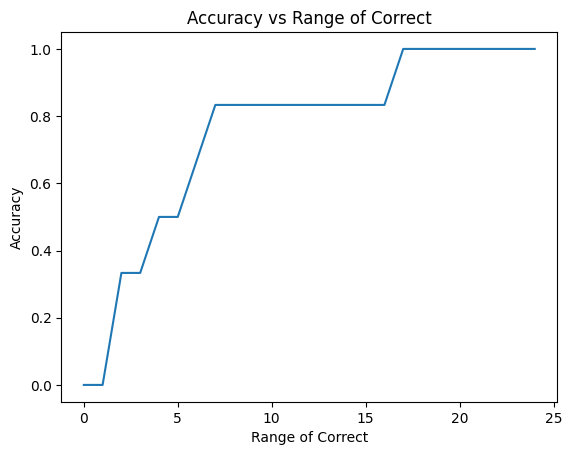

In [10]:
#check accuracy
correct = 0
total = 0


def getGradeRange(rangeofCorrect):
    correct = 0
    total = 0
    for i in combinedDF.index:
        if (combinedDF.at[i, "predictedGrade"] <= combinedDF.at[i, "fileGrade"] + rangeofCorrect and combinedDF.at[i, "predictedGrade"] >= combinedDF.at[i, "fileGrade"] - rangeofCorrect):
            correct += 1
        total += 1
    return correct, total



#generate a graph
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(0, 25, 1)
y = []
for i in x:
    correct, total = getGradeRange(i)
    y.append(correct/total)
plt.plot(x, y)
plt.xlabel('Range of Correct')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Range of Correct')
plt.show()




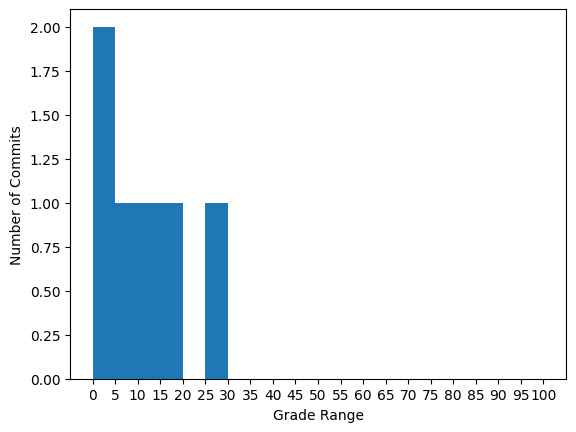

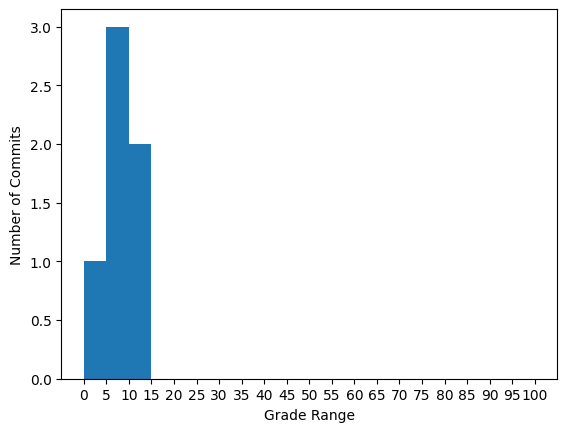

In [11]:
#generate graph showing range of grades
graph = plt.hist(combinedDF['fileGrade'], bins=20, range=(0, 100))
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
plt.xlabel("Grade Range")
plt.ylabel("Number of Commits")
plt.show()

graph = plt.hist(combinedDF['predictedGrade'], bins=20, range=(0, 100))
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
plt.xlabel("Grade Range")
plt.ylabel("Number of Commits")
plt.show()

In [12]:
incriments = 20
rangeofCorrect = 5

#break up the data into incriments
for i in range(incriments):
    #get the data for the incriments
    incrimentsDF = combinedDF[(combinedDF["fileGrade"] >= i * 100 / incriments) & (combinedDF["fileGrade"] < (i + 1) * 100 / incriments)]
    #get the accuracy for the incriments
    correct = 0
    total = 0
    for j in incrimentsDF.index:
        if (incrimentsDF.at[j, "predictedGrade"] <= incrimentsDF.at[j, "fileGrade"] + rangeofCorrect and incrimentsDF.at[j, "predictedGrade"] >= incrimentsDF.at[j, "fileGrade"] - rangeofCorrect):
            correct += 1
        total += 1
    #print the accuracy
    if(total != 0):
        print ("Accuracy for incriments " + str(i * 100 / incriments) + "% - " + str((i + 1) * 100 / incriments) + "%: " + str(correct/total * 100) + "%")


Accuracy for incriments 0.0% - 5.0%: 100.0%
Accuracy for incriments 5.0% - 10.0%: 100.0%
Accuracy for incriments 10.0% - 15.0%: 0.0%
Accuracy for incriments 15.0% - 20.0%: 0.0%
Accuracy for incriments 25.0% - 30.0%: 0.0%


In [13]:
#comparitive commits tests

#Make an array of dataframes which are created from combinedDF, and are split by their original file

#Get the list of files
files = combinedDF["Path"]


#split all the files by the last / and get the first element of the split

files = [file.rsplit("/",1)[0] for file in files]
#remove duplicates
files = list(dict.fromkeys(files))

#reset index

#make an array of dataframes
dataframes = []
for i in range(len(files)):
    dataframes.append([])
for i in combinedDF.index:
    #get index of files where the file name is the same as the current file name
    index = files.index(combinedDF.at[i, "Path"].rsplit("/",1)[0])
    dataframes[index].append(combinedDF.iloc[i])

In [14]:
#per file commit simple test, checks if the previous commit is less than or equal to the current commit
correct = 0
equal = 0
total = 0
for dataframe in dataframes:
    for i in range(1, len(dataframe)):
        #make sure that the length of the dataframe is greater than 1
        if (dataframe[i]["predictedGrade"] > dataframe[i - 1]["predictedGrade"]):
            correct += 1
            total += 1
        elif (dataframe[i]["predictedGrade"] == dataframe[i - 1]["predictedGrade"]):
            equal += 1
        else:
            total += 1
print ("Accuracy for per commit simple test: " + str(correct/total * 100) + "%")

Accuracy for per commit simple test: 100.0%


In [17]:
#per file commit gap test, checks if the previous commit is less than or equal to the current commit in a gap of 10

def gapTest(gap):
    correct = 0
    equal = 0
    total = 0
    avgCorrectScore = 0
    avgIncorrectScore = 0
    for dataframe in dataframes:
        for i in range(gap, len(dataframe)):
            #make sure that the length of the dataframe is greater than 1
            if (dataframe[i]["predictedGrade"] > dataframe[i - gap]["predictedGrade"]):
                correct += 1
                avgCorrectScore += dataframe[i]["predictedGrade"] - dataframe[i - gap]["predictedGrade"]
                total += 1
            elif (dataframe[i]["predictedGrade"] == dataframe[i - gap]["predictedGrade"]):
                equal += 1
            else:
                avgIncorrectScore += dataframe[i]["predictedGrade"] - dataframe[i - gap]["predictedGrade"]
                total += 1
    if (total != 0):
        avgCorrectScore /= correct
        try:
            avgIncorrectScore /= total - correct
        except:
            avgIncorrectScore = 0
        print ("Average correct score: " + str(avgCorrectScore))
        print ("Average incorrect score: " + str(avgIncorrectScore))
    if (total == 0):
        print ("This data is junk")
    print ("Accuracy for per file commit gap test of size " + str(gap) + " : " + str(correct/total * 100) + "%")

    return correct/total * 100 


for i in range(1, 100):
    gapTest(i)

#graph this
x = []
y = []
for i in range(1, 100):
    x.append(i)
    y.append(gapTest(i))
plt.plot(x, y)
plt.xlabel("Gap Size")
plt.ylabel("Accuracy")
plt.show()


Average correct score: 1.1155866384506226
Average incorrect score: 0
Accuracy for per file commit gap test of size 1 : 100.0%
Average correct score: 2.288468599319458
Average incorrect score: 0
Accuracy for per file commit gap test of size 2 : 100.0%
Average correct score: 4.358474254608154
Average incorrect score: 0
Accuracy for per file commit gap test of size 3 : 100.0%
This data is junk


ZeroDivisionError: division by zero